In [1]:
import pandas as pd
import numpy as np
import glob
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
import networkx as nx # for visualizing graphs
from sklearn.preprocessing import StandardScaler

import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch.optim as optim
from copy import deepcopy
from torch_geometric.nn import GINConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.metrics import *
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch

/clusterfs/ml4hep/mpettee/miniconda3/envs/pytorch_geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Simple example:

In [ ]:
# Define two (bidirectional) edges: between nodes [0,1] and between nodes [1,2]:
edge_index = torch.tensor([[0, 1, 1, 2], 
                           [1, 0, 2, 1]], dtype=torch.long)

# Define node features 
x = torch.tensor([[-1], # node 0
                  [0],  # node 1
                  [1]], # node 2
                 dtype=torch.float)

# Put it all together
data = Data(x=x, edge_index=edge_index)

In [ ]:
plt.figure() 
nx.draw(to_networkx(data), 
        cmap='plasma', 
        node_color = np.arange(data.num_nodes),
        with_labels=True,
        font_weight='bold',
        font_color='white',
        node_size=400, linewidths=6)

In [ ]:
print("Graph nodes have {} node feature(s) each.".format(data.num_node_features))
print("Graph has {} nodes and {} edges.".format(data.num_nodes, data.num_edges))
print("Is the graph undirected?: {}".format(data.is_undirected()))

# Load the ENZYMES dataset & visualize it

In [ ]:
# load the dataset
from torch_geometric.datasets import TUDataset
enzymes = TUDataset(root='/tmp/ENZYMES', name='ENZYMES') 
print("Dataset has {} entries, with {} classes and {} node features.".format(len(enzymes), 
                                                                             enzymes.num_classes, 
                                                                             enzymes.num_node_features))
print("First entry has {:,} nodes and {:,} edges.".format(enzymes[0].num_nodes, enzymes[0].num_edges))
print("Is the graph undirected?: {}".format(enzymes[0].is_undirected()))

# now turn it into graphs
graphs = GraphDataset.pyg_to_graphs(enzymes) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print("Dataset has {} classes".format(dataset.num_graph_labels))
print("Dataset has {} node features".format(dataset.num_node_features))

In [ ]:
plt.figure() 
print(enzymes[500].y) # overall class of this protein
graph = enzymes[500]
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=6)

In [ ]:
def visualize(dataset):
    color_mapping = {
        0 : 'black',
        1 : 'red',
        2 : 'green',
        3 : 'yellow',
        4 : 'blue',
        5 : 'purple',
    }
    num_graphs_i = 3
    num_graphs_j = 3
    fig, ax = plt.subplots(num_graphs_i, num_graphs_j, figsize=(11, 11))
    fig.suptitle("ENZYMES Graphs Visualization", fontsize=16)
    indices = np.random.choice(np.arange(0, len(dataset)), size=9, replace=False)
    indices = indices.reshape(3, 3)
    for i in range(num_graphs_i):
        for j in range(num_graphs_j):
            index = int(indices[i, j])
            G = dataset[index].G
            label = dataset[index].graph_label.item()
            pos = nx.spring_layout(G, seed=1)
            colors = [color_mapping[label]] * dataset[index].num_nodes
            nodes = nx.draw_networkx_nodes(G, pos=pos, cmap=plt.get_cmap('coolwarm'), \
                node_size=30, ax=ax[(i, j)], node_color=colors)
            nodes.set_edgecolor('black')
            nx.draw_networkx_edges(G, pos=pos, ax=ax[(i, j)])
            ax[(i, j)].set_title("Sample graph with label {}".format(label), fontsize=13)
            ax[(i, j)].set_axis_off()
    plt.show()
visualize(dataset)

Define a basic GNN for graph classification:

In [ ]:
class GIN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GIN, self).__init__()
        self.num_layers = args["num_layers"]

        self.pre_mp = nn.Linear(input_size, hidden_size)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(self.num_layers):
            layer = Sequential(
                Linear(hidden_size, hidden_size), 
                nn.LeakyReLU(), 
                Linear(hidden_size, hidden_size)
            )
            self.convs.append(GINConv(layer))
            self.bns.append(nn.BatchNorm1d(hidden_size))
        self.post_mp = Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        x = self.pre_mp(x)
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
        x = self.convs[-1](x, edge_index)
        x = pyg_nn.global_add_pool(x, batch)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

Define train & test functions:

In [ ]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, device="cpu"):
    model = GIN(num_node_features, args["hidden_size"], num_classes, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.graph_label
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    correct = 0
    num_graphs = 0
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            label = batch.graph_label
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
    return correct / num_graphs

Train!

In [ ]:
args = {
    "device" : 'cpu', # 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 50,
    "epochs" : 10,
    "lr" : 0.001,
    "num_layers": 3,
    "dataset" : "ENZYMES",
    "batch_size": 32,
}

pyg_dataset = TUDataset('./tmp/enzymes', args["dataset"])
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])
num_node_features = dataset.num_node_features
num_classes = dataset.num_graph_labels

In [ ]:
train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

In [ ]:
best_model = train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])
train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

In [ ]:
def test_with_printouts(loader, model, device='cuda'): # with printouts
    model.eval()
    correct = 0
    num_graphs = 0
    batch_num = 0
    for batch in loader:
        print("====== BATCH {} ======".format(batch_num))
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            print("Predicted labels:", pred)
            label = batch.graph_label
            print("True labels:", label)
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
        batch_num += 1
        print("Total graphs in batch:", batch.num_graphs)
        print("Number correctly predicted:", pred.eq(label).sum().item())
        print("Accuracy = {:.2f}%".format(100*pred.eq(label).sum().item()/batch.num_graphs))
    print("\nOut of all {} test graphs, {} predictions were correct.".format(num_graphs, correct))
    print("Total accuracy = {:.2f}%".format(100*correct/num_graphs))       
    return correct / num_graphs

In [ ]:
test_acc = test_with_printouts(test_loader, best_model, args["device"])

# Okay, now try doing classification on pions as graphs! 

In [ ]:
### Load data (multiple files)
pion_files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
pi0_files = glob.glob("../data/onetrack_multicluster/pi0_files/*.npy") # obviously very few of these pass the STMC cuts

df_pion = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pion_files[:1])])
df_pi0 = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pi0_files)])

print("Pion dataframe has {:,} events.".format(df_pion.shape[0]))
print("Pi0 dataframe has {:,} events.".format(df_pi0.shape[0]))

In [ ]:
def clean_dataframe(df, is_charged = True, max_n_cols=35): 
    ### Start the dataframe of inputs 
    # df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())[0]) # just take the leading cluster E 
    df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(max_n_cols)]))
    
    ### Add track pT & truth particle E 
    track_pt = np.array(df.trackPt.explode())
    truth_particle_e = np.array(df.truthPartE.explode())
    track_eta = np.array(df.trackEta.explode())
    track_phi = np.array(df.trackPhi.explode())
    track_z0 = np.array(df.trackZ0.explode())

    df2["track_pt"] = track_pt
    df2["track_eta"] = track_eta
    df2["track_phi"] = track_phi
    df2["track_z0"] = track_z0
    if is_charged:
        df2["truth_particle_e"] = truth_particle_e
    else:
        df3 = pd.DataFrame(pd.DataFrame(df.truthPartE.to_list(), columns=["truth_particle_e_"+str(x) for x in np.arange(4)]))
        df2["truth_particle_e"] = df3.truth_particle_e_0
        
    ### Cluster_E > 0.5
    df2 = df2[df2.cluster_e_0 > 0.5]

    ### Lose outliers in track pT 
    df2 = df2[df2.track_pt < 5000]

    ### Cast as float
    df2 = df2.astype('float32')

    ### Add the log of all energy variables
    for var in df2.keys():
        if var in ["track_eta", "track_phi", "track_z0"]:
            continue
        else:
            df2['log10_'+var] = np.log10(df2[var])

    ### Drop infs/NaNs 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)
    
    ### Reduce variables
    
    vars = [
    'log10_cluster_e_0', 
    'log10_track_pt',
    'track_eta', 
    'truth_particle_e'
             ]
    
    df2 = df2[vars]
    
    if is_charged:
        df2['label'] = 1
    else:
        df2['label'] = 0
        
    return df2

In [ ]:
df_pion = clean_dataframe(df_pion, is_charged = True, max_n_cols=24)
df_pion

In [ ]:
df_pi0 = clean_dataframe(df_pi0, is_charged = False, max_n_cols=13)
df_pi0

In [ ]:
df = pd.concat([df_pion, df_pi0])
df = df.sample(frac=1) # shuffle the rows, for good measure
df

In [ ]:
class PionDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataframe):
        'Initialization'
        self.dataframe = dataframe
        print("")

    def __len__(self):
        'Denotes the total number of samples'
        dataframe = self.dataframe
        return len(dataframe)

    def __getitem__(self, index):
        'Generates one sample of data'  
        dataframe = self.dataframe
        
        ### define nodes 
        cluster_features = ['log10_cluster_e_0']
        track_features = ['log10_track_pt', 'track_eta']
        
        cluster_node = np.array(dataframe.iloc[index][cluster_features])
        cluster_node = np.concatenate([cluster_node, np.zeros(2)]) # cluster features come first
        
        track_node = np.array(dataframe.iloc[index][track_features])
        track_node = np.concatenate([np.zeros(1), track_node]) # cluster features come first

        # shape = (num_nodes, num_node_features) = (2, 3)
        nodes = np.vstack([cluster_node, track_node])        
        
        ### define edges (fully-connected, but no self-loops)
        edges = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edges_reversed = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edge_index = np.row_stack([edges,edges_reversed])
        
        ### Define target 
        label = np.array([dataframe.iloc[index]['label']])
        
        # Convert to torch objects
        nodes = torch.Tensor(nodes)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        label = torch.from_numpy(label).long()
#         edge_attr = torch.Tensor(is_skeleton_edge)
        
        return Data(x=nodes, y=label, edge_index=edge_index.t().contiguous(), 
#                     edge_attr=edge_attr
                   )

Generate pion graphs:

In [ ]:
pions = PionDataset(df)
graphs = GraphDataset.pyg_to_graphs(pions) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print("Dataset has {} classes".format(dataset.num_graph_labels))
print(len(dataset))
# print("Dataset has {} node features".format(dataset.num_node_features))

In [ ]:
def visualize(dataset):
    color_mapping = {
        0 : 'black',
        1 : 'red',
        2 : 'green',
        3 : 'yellow',
        4 : 'blue',
        5 : 'purple',
    }
    num_graphs_i = 3
    num_graphs_j = 3
    fig, ax = plt.subplots(num_graphs_i, num_graphs_j, figsize=(11, 11))
    fig.suptitle("Pion Graph Visualization", fontsize=16)
    indices = np.random.choice(np.arange(0, len(dataset)), size=9, replace=False)
    indices = indices.reshape(3, 3)
    for i in range(num_graphs_i):
        for j in range(num_graphs_j):
            index = int(indices[i, j])
            G = dataset[index].G
            label = dataset[index].graph_label.item()
            pos = nx.spring_layout(G, seed=1)
            colors = [color_mapping[label]] * dataset[index].num_nodes
            nodes = nx.draw_networkx_nodes(G, pos=pos, cmap=plt.get_cmap('coolwarm'), \
                node_size=30, ax=ax[(i, j)], node_color=colors)
            nodes.set_edgecolor('black')
            nx.draw_networkx_edges(G, pos=pos, ax=ax[(i, j)])
            ax[(i, j)].set_title("Sample graph with label {}".format(label), fontsize=13)
            ax[(i, j)].set_axis_off()
    plt.show()
visualize(dataset)

Visualize a single pion event as a graph:

In [ ]:
plt.figure() 
graph = dataset[15]
print(graph)
print(graph.node_feature)
if graph.graph_label == 0:
    print("Neutral pion")
elif graph.graph_label == 1:
    print("Charged pion")
print(graph.graph_label)
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=6)

In [ ]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, device="cpu"):
    model = GIN(num_node_features, args["hidden_size"], num_classes, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.graph_label
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    correct = 0
    num_graphs = 0
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            label = batch.graph_label
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
    return correct / num_graphs

In [ ]:
args = {
    "device" : 'cpu', # 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 50,
    "epochs" : 10,
    "lr" : 0.001,
    "num_layers": 3,
    "batch_size": 32,
}

dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])

num_node_features = 3
num_classes = dataset.num_graph_labels

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

best_model = train(train_loader, val_loader, test_loader, args, 
                   num_node_features, num_classes, args["device"])

train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

In [ ]:
test_acc = test_with_printouts(test_loader, best_model, args["device"])

# Pion regression

In [2]:
### Load data (multiple files)
n_files = 1
pion_files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
df_pion = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pion_files[:n_files])])
print("Pion dataframe has {:,} events.".format(df_pion.shape[0]))

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Pion dataframe has 10,249 events.


In [3]:
def clean_dataframe(df): 
    ### Start the dataframe of inputs 
    max_n_cols = pd.DataFrame(df.cluster_E.to_list()).shape[1]
    df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(max_n_cols)]))
    
    df3 = pd.DataFrame(pd.DataFrame(df.cluster_Eta.to_list(), columns=["cluster_eta_"+str(x) for x in np.arange(max_n_cols)]))
    df2['cluster_eta_0'] = df3['cluster_eta_0'] 
    
    df3 = pd.DataFrame(pd.DataFrame(df.cluster_Phi.to_list(), columns=["cluster_phi_"+str(x) for x in np.arange(max_n_cols)]))
    df2['cluster_phi_0'] = df3['cluster_phi_0']   
    
    ### Add cluster cell energy
    cluster_cell_e = []
    for i in range(len(df2)): 
        cluster_cell_e.append(np.array(np.log10(df.cluster_cell_E.iloc[i][0]))) # only cells from leading cluster
    df3["cluster_cell_e"] = cluster_cell_e
    max_n_cells = pd.DataFrame(df3.cluster_cell_e.to_list()).shape[1]
    df_cells = pd.DataFrame(pd.DataFrame(df3.cluster_cell_e.to_list(), columns=["cluster_cell_e_"+str(x) for x in np.arange(max_n_cells)]))
    df2 = pd.concat([df2, df_cells], axis="columns")
    
    ### Add track pT & truth particle E 
    track_pt = np.array(df.trackPt.explode())
    truth_particle_e = np.array(df.truthPartE.explode())
    track_eta = np.array(df.trackEta.explode())
    track_phi = np.array(df.trackPhi.explode())
    track_z0 = np.array(df.trackZ0.explode())

    df2["track_pt"] = track_pt
    df2["track_eta"] = track_eta
    df2["track_phi"] = track_phi
    df2["track_z0"] = track_z0
    df2["truth_particle_e"] = truth_particle_e
        
    ### Cluster_E > 0.5
    df2 = df2[df2.cluster_e_0 > 0.5]

    ### Lose outliers in track pT 
    df2 = df2[df2.track_pt < 5000]
    
    ### Cast as float
    df2 = df2.astype('float32')

    ### Add the log of all energy variables
    for var in df2.keys():
        if var in ["track_eta", "track_phi", "track_z0", "cluster_cell_e", "cluster_eta", "cluster_phi"]:
            continue
        elif "cell" in var:
            continue
        else:
            df2['log10_'+var] = np.log10(df2[var])

    ### Drop infs/NaNs 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)
    
    ### Reduce variables
    vars = [
    'log10_cluster_e_0', 
    'log10_track_pt',
    'track_eta', 
    'track_phi',
    'track_z0',
    'log10_truth_particle_e',
    'cluster_eta_0',
    'cluster_phi_0',
             ]
    
    vars += [var for var in df2.keys() if "cell" in var]
    
    df2 = df2[vars]
    
    ### Standardize inputs
    sc = StandardScaler()
    x = df2.values
    x = sc.fit_transform(x)
    
    for i in range(len(vars)):
        df2[vars[i]+"_scaled"] = x[:,i]
        
    df2['num_cells_lead_cluster'] = np.sum(df2[[var for var in df2.keys() if "scaled" not in var and "cell" in var]] != 0, axis=1)
        
    ### Get rid of any duplicate target values
    df2.reset_index(drop=True, inplace=True)
    series = df2.log10_truth_particle_e_scaled
    indices_to_drop = series[series.duplicated()].index
    df2.drop(indices_to_drop, inplace=True)
    df2.reset_index(drop=True, inplace=True)

    return df2

In [59]:
df = clean_dataframe(df_pion[:1000])

/clusterfs/ml4hep/mpettee/miniconda3/envs/pytorch_geo/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/clusterfs/ml4hep/mpettee/miniconda3/envs/pytorch_geo/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_13318/2983635687.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[vars[i]+"_scaled"] = x[:,i]
/tmp/ipykernel_13318/2983635687.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [60]:
class PionDataset_Regress(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataframe, cluster_features, track_features):
        'Initialization'
        self.dataframe = dataframe
        self.cluster_features = cluster_features
        self.track_features = track_features
        print("")

    def __len__(self):
        'Denotes the total number of samples'
        dataframe = self.dataframe
        return len(dataframe)

    def __getitem__(self, index):
        'Generates one sample of data'  
        dataframe = self.dataframe
        
        ### define nodes 
        cell_info = ['cluster_cell_e_'+str(i)+'_scaled' for i in range(int(dataframe.iloc[index].num_cells_lead_cluster))]
        cluster_nodes = np.zeros((int(dataframe.iloc[index].num_cells_lead_cluster), 1+len(cluster_features)+len(track_features)))
        cluster_nodes[:,0] = dataframe.iloc[index][cell_info]
        
        cluster_global_node = np.array(dataframe.iloc[index][cluster_features])
        cluster_global_node = np.concatenate([np.zeros(1), cluster_global_node, np.zeros(len(track_features))]) # cluster features come first
        
        track_node = np.array(dataframe.iloc[index][track_features])
        track_node = np.concatenate([np.zeros(len(cluster_features)+1), track_node]) # cluster features come first
        
        # shape = (num_nodes, num_node_features) = (2, 3)
        nodes = np.vstack([cluster_nodes, cluster_global_node, track_node]) 
        
        ### define edges (fully-connected, but no self-loops)
        edges = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edges_reversed = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edge_index = np.row_stack([edges,edges_reversed])
        
        ### Define target 
        target = np.array([dataframe.iloc[index]['log10_truth_particle_e']])
        
        # Convert to torch objects
        nodes = torch.Tensor(nodes)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        target = torch.tensor(target)
#         edge_attr = torch.Tensor(is_skeleton_edge)
        
        return Data(x=nodes, y=target, edge_index=edge_index.t().contiguous(), 
#                     edge_attr=edge_attr
                   )

In [61]:
cluster_features = ['log10_cluster_e_0_scaled']
track_features = ['log10_track_pt_scaled', 'track_eta_scaled', 'track_phi_scaled', 'track_z0_scaled']
pions = PionDataset_Regress(df, cluster_features, track_features)
graphs = GraphDataset.pyg_to_graphs(pions) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print(len(dataset))
print("Dataset has {} node features".format(dataset.num_node_features))


968
Dataset has 6 node features


Graph(G=[], edge_index=[2, 5402], edge_label_index=[2, 5402], graph_label=[1], node_feature=[74, 6], node_label_index=[74], task=[])
tensor([[ 1.7460e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 7.3368e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 7.2248e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1627e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 6.0080e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 6.8624e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.2815e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 7.9647e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 3.8581e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e

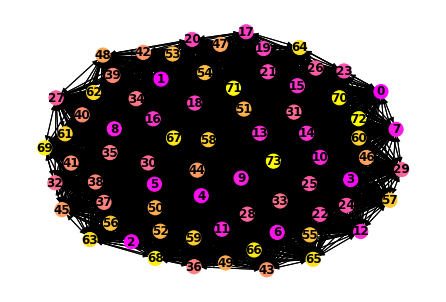

In [62]:
plt.figure() 
graph = dataset[0]
print(graph)
print(graph.node_feature)
print(graph.graph_label)
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=1)

In [63]:
class GIN_Regress(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GIN_Regress, self).__init__()
        self.num_layers = args["num_layers"]
        self.pre_mp = nn.Linear(input_size, hidden_size)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(self.num_layers):
            layer = Sequential(
                Linear(hidden_size, hidden_size), 
                nn.ReLU(), 
                Linear(hidden_size, hidden_size)
            )
            self.convs.append(GINConv(layer))
            self.bns.append(nn.BatchNorm1d(hidden_size))
        self.post_mp = Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(), 
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        x = self.pre_mp(x)
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
        x = self.convs[-1](x, edge_index)
        x = pyg_nn.global_mean_pool(x, batch)
        x = self.post_mp(x)
        return x

    def loss(self, pred, target):
        pred = pred.reshape(pred.shape[0])
        return F.mse_loss(pred, target)

In [64]:
def train(train_loader, val_loader, test_loader, args, num_node_features, output_size, device="cpu"):
    model = GIN_Regress(num_node_features, args["hidden_size"], 1, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        t0 = time.time() 
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            target = batch.graph_label
            loss = model.loss(pred.float(), target.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {} (took {:.2f} seconds): Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, time.time() - t0, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    ratio = []
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch)[:,0] # to make the shapes match
            target = batch.graph_label
            ratio.append(torch.median(torch.divide(pred, target))) 
    return np.mean(np.array(ratio))

def test_after_training(loader, model, device='cuda'):
    model.eval()
    preds = []
    targets = []
    ratio = []
    batch_num = 0
    for batch in loader:
#         print("====== BATCH {} ======".format(batch_num))
        batch.to(device)
        with torch.no_grad():
            pred = model(batch)[:,0] # to make the shapes match
            preds.append(pred)
#             print("Predicted energies:", pred)
            target = batch.graph_label
            targets.append(target)
#             print("Truth energies:", target)
#             print("Ratios:", torch.divide(pred, target))
        ratio.append(torch.median(torch.divide(pred, target))) 
        batch_num += 1
#         print("Median ratio per batch: {}".format(torch.median(torch.divide(pred, target))))
    preds_reshaped = torch.cat([torch.stack(preds[:-1]).view(-1, 1), preds[-1].view(-1, 1)])
    targets_reshaped = torch.cat([torch.stack(targets[:-1]).view(-1, 1), targets[-1].view(-1, 1)])
    return np.median(np.array(ratio)), preds_reshaped, targets_reshaped

In [86]:
args = {
    "device" : 'cpu', #'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 10,
    "epochs" : 100,
    "lr" : 0.001,
    "num_layers": 3,
    "batch_size": 32,
}

dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])

num_node_features = len(cluster_features)+len(track_features)+1

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

best_model = train(train_loader, val_loader, test_loader, args, 
                   num_node_features, 1, args["device"])

train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])

# Values printed are best median ratio of predicted energy to target:
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

Epoch 1 (took 8.55 seconds): Train: 0.1187, Validation: 0.1319. Test: 0.1248, Loss: 6.3045
Epoch 2 (took 8.38 seconds): Train: 0.3063, Validation: 0.3300. Test: 0.2994, Loss: 2.6134
Epoch 3 (took 8.46 seconds): Train: 0.3728, Validation: 0.4346. Test: 0.3959, Loss: 2.0395
Epoch 4 (took 8.39 seconds): Train: 0.4788, Validation: 0.5531. Test: 0.4997, Loss: 1.5139
Epoch 5 (took 8.47 seconds): Train: 0.5155, Validation: 0.5196. Test: 0.4831, Loss: 1.2635
Epoch 6 (took 8.46 seconds): Train: 0.5039, Validation: 0.5761. Test: 0.5012, Loss: 1.1931
Epoch 7 (took 8.52 seconds): Train: 0.5560, Validation: 0.6141. Test: 0.6042, Loss: 1.0056
Epoch 8 (took 8.44 seconds): Train: 0.6745, Validation: 0.7464. Test: 0.6618, Loss: 0.9400
Epoch 9 (took 8.38 seconds): Train: 0.7117, Validation: 0.7351. Test: 0.6994, Loss: 0.7082
Epoch 10 (took 8.50 seconds): Train: 0.7283, Validation: 0.7542. Test: 0.7315, Loss: 0.8205
Epoch 11 (took 8.40 seconds): Train: 0.7730, Validation: 0.8350. Test: 0.8082, Loss: 0.72

#### Make plots:

In [87]:
median_ratio, preds, targets = test_after_training(test_loader, best_model, args["device"])
print(median_ratio)

1.1526606348539752


In [88]:
test_df = df.loc[df['log10_truth_particle_e'].isin(np.array(targets[:,0]))]
test_df = test_df.sort_values('log10_truth_particle_e')

nn_outputs = pd.DataFrame(np.vstack([np.array(preds[:,0]), np.array(targets[:,0])]).T,
             columns = ["preds", "targets"])
nn_outputs = nn_outputs.sort_values('targets')

test_df["nn_preds"] = np.array(nn_outputs.preds)
test_df["nn_targets"] = np.array(nn_outputs.targets)

In [89]:
test_df[['nn_preds', 'nn_targets']]

,nn_preds,nn_targets
304,1.106762,0.375356
810,0.911494,0.534520
893,0.710983,0.543274
505,0.985993,0.565923
160,1.034332,0.609522
...,...,...
284,3.073308,3.243715
712,2.588757,3.246669
291,1.979720,3.261712
698,3.126621,3.264665


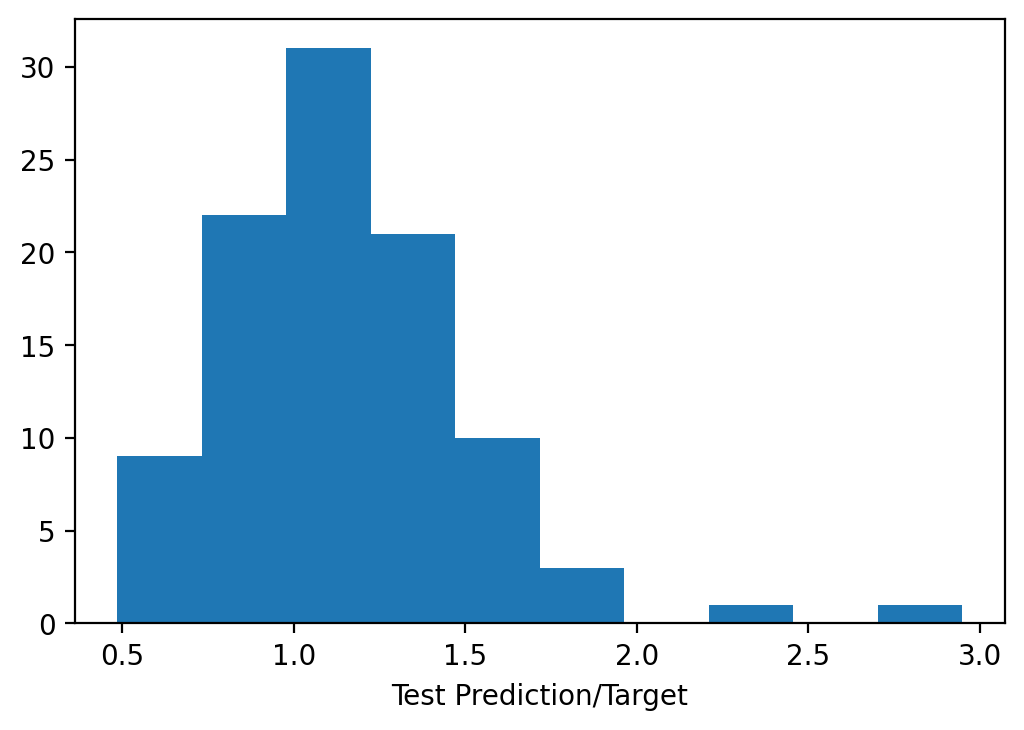

In [118]:
plt.figure(dpi=200)
plt.hist(test_df.nn_preds/test_df.nn_targets, 
         bins=10
#          bins=np.linspace(0.5,1.5,10)
        );
plt.xlabel("Test Prediction/Target");

In [116]:
test_df.nn_preds/test_df.nn_targets

304    2.948564
810    1.705258
893    1.308700
505    1.742274
160    1.696955
         ...   
284    0.947466
712    0.797358
291    0.606957
698    0.957716
576    1.379198
Length: 98, dtype: float64

In [107]:
profileXMed

array([       nan, 2.08446559, 1.49125206, 2.11380706])

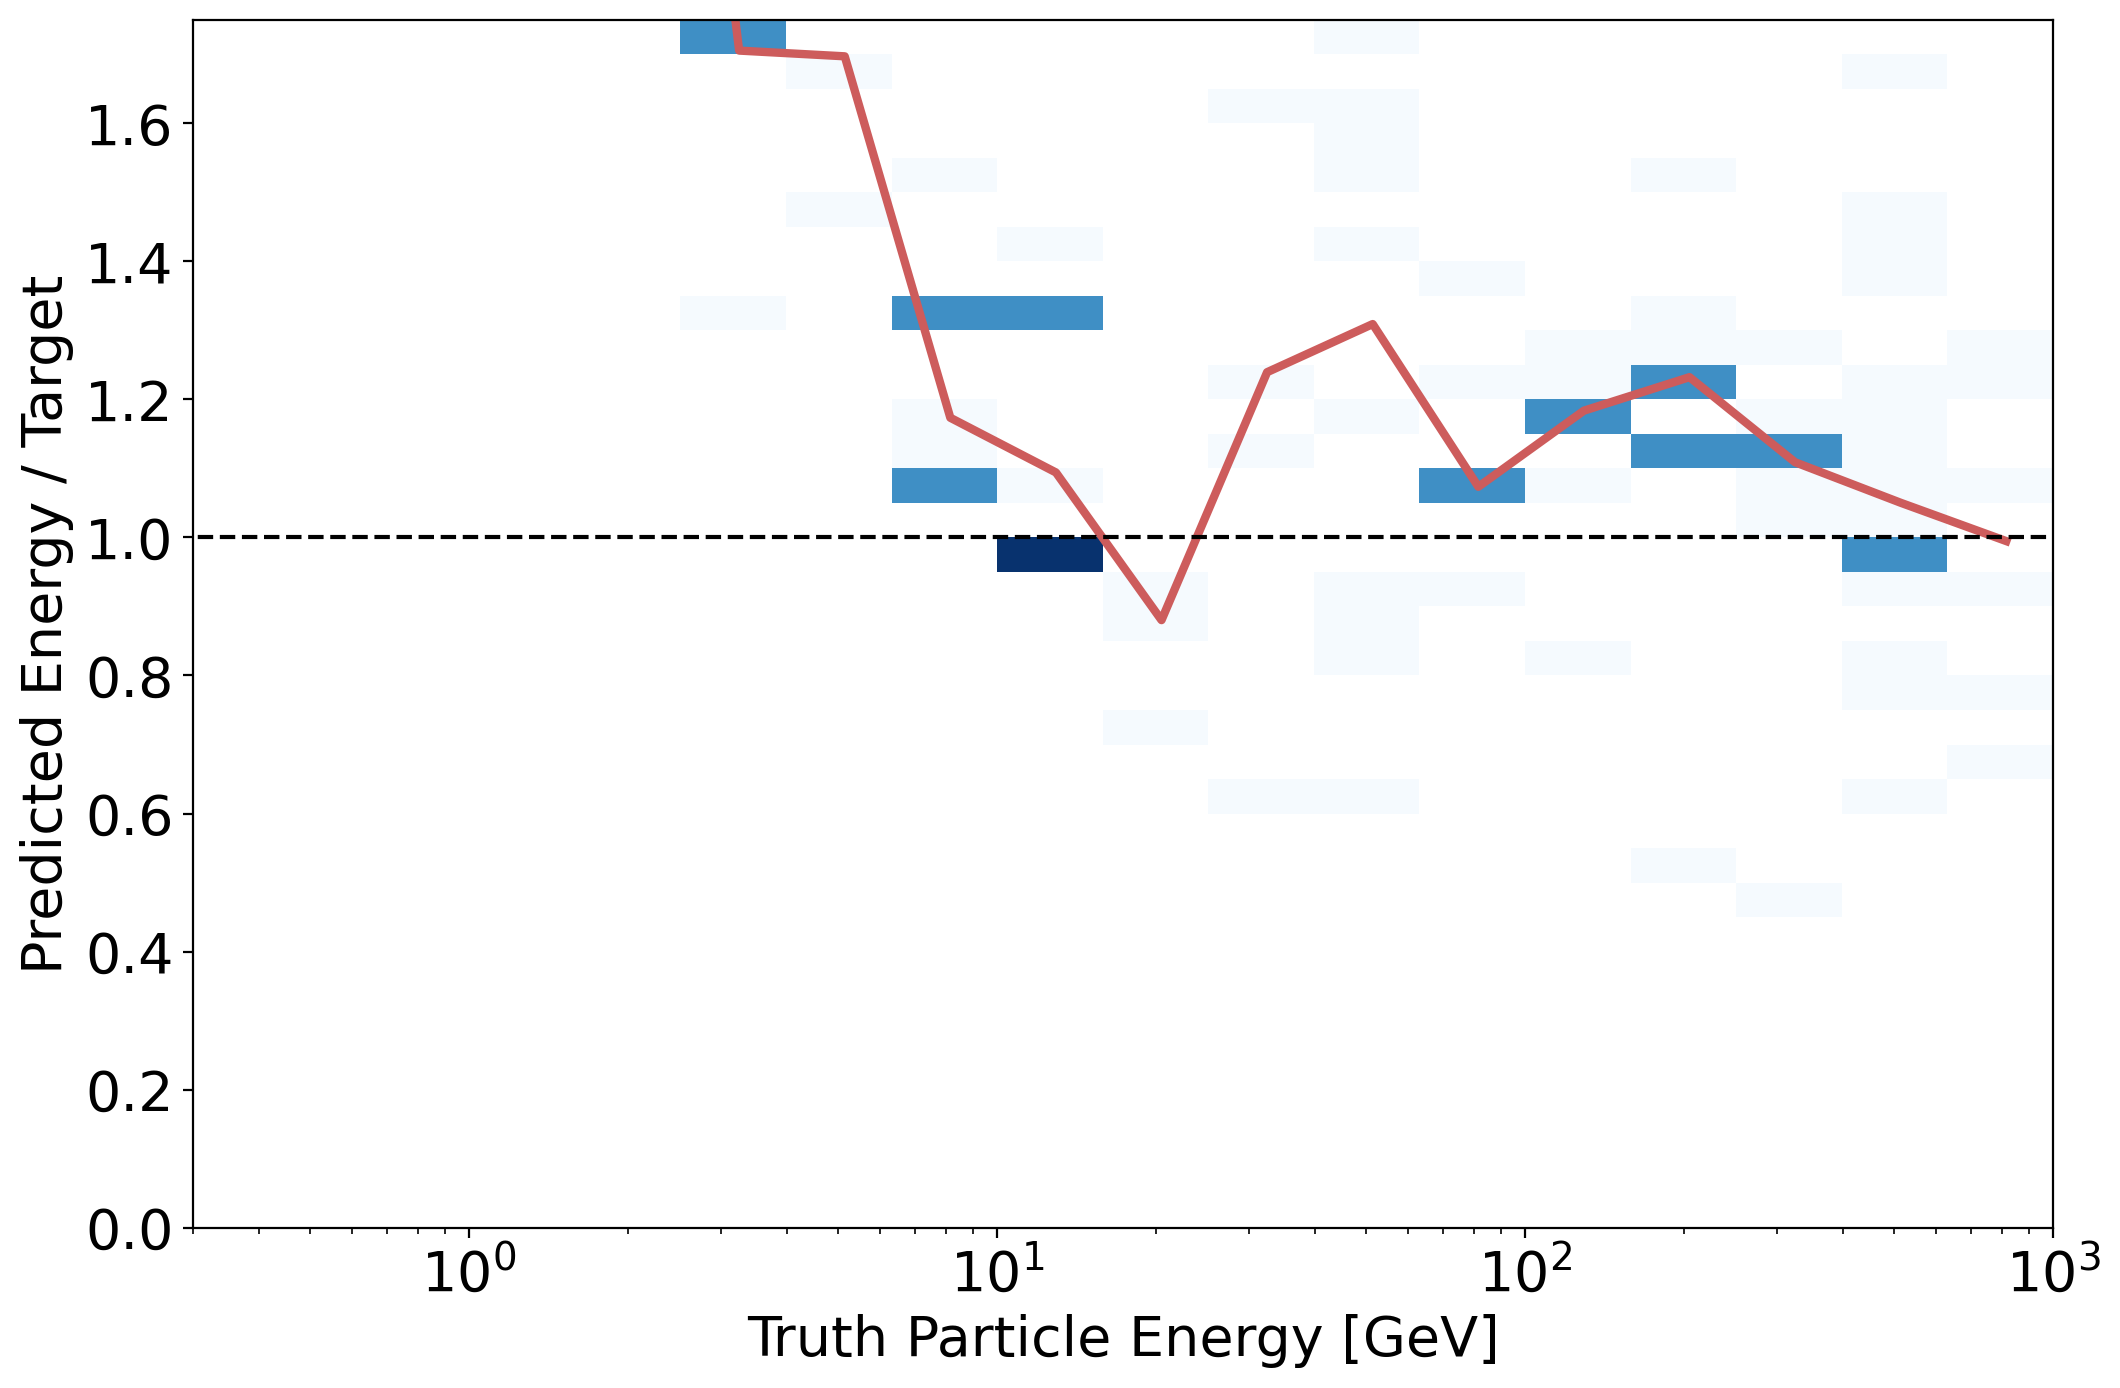

In [125]:
### Response median plot 
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = 10**test_df.log10_truth_particle_e
y = test_df.nn_preds/test_df.nn_targets

# xbin = [10**exp for exp in np.arange(-1., 3.1, 0.05)]
xbin = [10**exp for exp in np.arange(-1., 3.1, 0.2)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8), dpi=200)
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Truth Particle Energy [GeV]', fontsize=20)
plt.ylabel('Predicted Energy / Target', fontsize=20);
# np.savez('pub_note_results/response_medians_simple_gnn_test.npz', response_median=profileXMed, xcenter=xcenter)

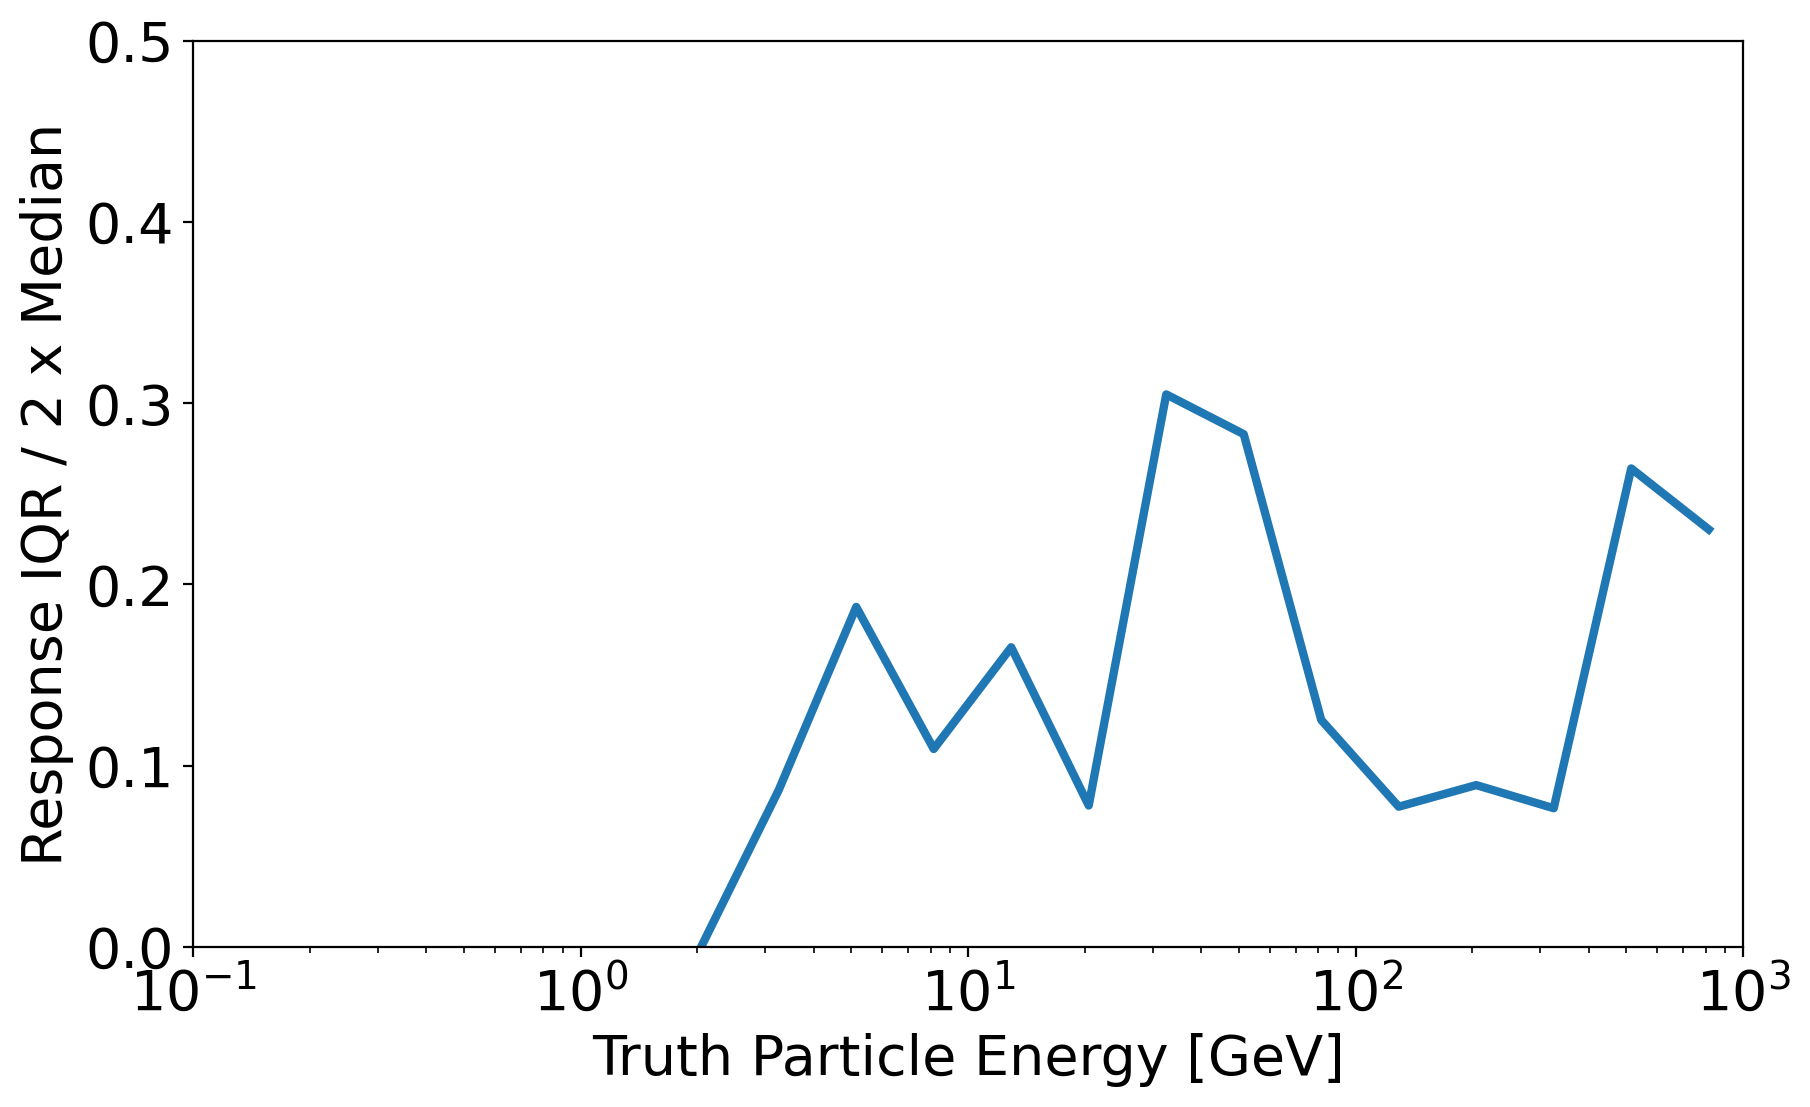

In [128]:
### IQR plot 

def iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)

# xbin = [10**exp for exp in np.arange(-1., 3.1, 0.1)]
xbin = [10**exp for exp in np.arange(-1., 3.1, 0.2)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

resolution = stats.binned_statistic(x, y, bins=xbin,statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6), dpi=200)
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]', fontsize=20);
plt.ylabel('Response IQR / 2 x Median', fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
# np.savez('pub_note_results/iqr_simple_gnn_test.npz', iqr=resolution, xcenter=xcenter)